In [5]:
import geopandas as gpd #for charting and mapping
import folium #ability to draw map on notebook
import os
from PIL import Image
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
#from geojson import Point
from geojson import Polygon
import geojson
import tempfile
import datetime as dt
from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio import plot
import rasterio.mask
import fiona
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from skimage import exposure

Moisture Index (B8A-B11)/(B8A+B11)

In [6]:
# import bands as separate 1 band raster

#imagePath = './data/2020\S2A_MSIL1C_20200628T094041_N0209_R036_T33SVV_20200628T105543.SAFE\GRANULE\L1C_T33SVV_A026202_20200628T094036\IMG_DATA/'
imagePath = '..\data\SelectedData\MoistIndex\S2A_MSIL1C_20171224T095421_N0206_R079_T33SVV_20171224T122256.SAFE\GRANULE\L1C_T33SVV_A013089_20171224T095627\IMG_DATA/'

# Load polygon vector of AI (e.g.Gozo) to clip satellite image
boundsdata = r'../data/gozocomino.geojson'
region = gpd.read_file(boundsdata)
print(region)
nReserve_proj = region.to_crs({'init': 'epsg:32633'})

   id                                           geometry
0   1  MULTIPOLYGON (((14.18335 36.07467, 14.18259 36...


C:\Users\MCAST\anaconda3\envs\remsen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
#15
#T33SVV_20150715T094306_B01

#16x
#T33SVV_20150715T094306_B01

#17
#T33SVV_20171025T095101_B01

#18
#T33SVV_20180423T095031_B01

#19
#T33SVV_20190428T095031_B01

#20
#T33SVV_20200628T094041_B01

#21
#B01

# Open b4 and b8
b8a = rasterio.open(imagePath+'T33SVV_20171224T095421_B8A.jp2')
b11 = rasterio.open(imagePath+'T33SVV_20171224T095421_B11.jp2')

# read Red(b4) and NIR(b8) as arrays
vnir = b8a.read()
swir = b11.read()

# Do not display error when divided by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate mIndex
mIndex = (vnir.astype(float)-swir.astype(float))/(vnir+swir)

#Print mIndex min and max
print(np.nanmin(mIndex))
print(np.nanmax(mIndex))

# get the dtype of our mIndex array:
mIndex_dtype = mIndex.dtype
print(mIndex_dtype)

# Write the mIndex image
meta = b8a.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float64)

with rasterio.open('../Output/mIndex.tif', 'w', **meta) as dst:
    dst.write(mIndex)
    #dst.write(ndvi.astype(rasterio.float32))

-1.0
0.9857142857142858
float64


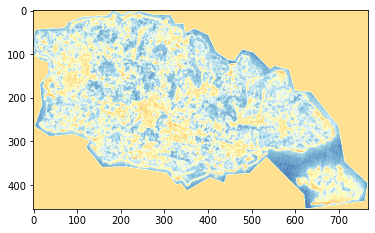

AttributeError: module 'rasterio.plot' has no attribute 'savefig'

In [8]:
# Crop NDVI to ROI

with rio.open("../Output/mIndex.tif") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open('../Output/mIndex_cropped.tif', 'w', **meta) as dst:
    dst.write(out_image)
plot.show(out_image, cmap='RdYlBu')


#Print NDVI min and max
print('Min mIndex:', np.nanmin(out_image))
print('Max mIndex:', np.nanmax(out_image))

In [ ]:
# Interpretation of mIndex


from matplotlib import colors


class MidpointNormalize(colors.Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):

        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

# Set min/max values from NDVI range for image

min=np.nanmin(out_image)
max=np.nanmax(out_image)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlBu
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111)

mIndex_cropped = rasterio.open("../Output/mIndex_cropped.tif")
# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
cbar_plot = ax.imshow(mIndex_cropped.read(1), cmap=colormap, vmin=min, vmax=max, norm=norm)


# Turn off the display of axis labels
ax.axis('off')

# Set a title
ax.set_title('Normalized Difference Moisture Index', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save this plot to an image file
fig.savefig("../Output/mIndex-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()

In [ ]:
# Generate histogram of mIndex

# Define a new figure
fig2 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = fig2.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("mIndex Histogram", fontsize=18, fontweight='bold')
plt.xlabel("mIndex values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)


# For the x-axis, we want to count every pixel that is not an empty value
x = mIndex_cropped.read(1)[~np.isnan(mIndex_cropped.read(1))]
color = 'g'
# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

# Save the generated figure to an external image file
fig2.savefig("../Output/mIndex-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)


plt.show()




